<a href="https://colab.research.google.com/github/valesierrai/Aprendizaje-No-Supervisado-para-el-AD/blob/main/Tarjetas_de_credito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aplicación de clúster

Se busca segmentar a los clientes con el fin de definir estrategias de marketing para tarjetas de crédito. Se dispone de datos sobre el uso de las tarjetas en los últimos 6 meses, y se pretende identificar diferentes segmentos de clientes para adaptar estrategias específicas a cada uno, con el objetivo de comprender mejor el perfil de los clientes.


CUST_ID : Identification of Credit Card holder (Categorical)

BALANCE : Balance amount left in their account to make purchases (

BALANCE_FREQUENCY : How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)

PURCHASES : Amount of purchases made from account

ONEOFF_PURCHASES : Maximum purchase amount done in one-go

INSTALLMENTS_PURCHASES : Amount of purchase done in installment

CASH_ADVANCE : Cash in advance given by the user

PURCHASES_FREQUENCY : How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)

ONEOFFPURCHASESFREQUENCY : How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)

PURCHASESINSTALLMENTSFREQUENCY : How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)

CASHADVANCEFREQUENCY : How frequently the cash in advance being paid

CASHADVANCETRX : Number of Transactions made with "Cash in Advanced"

PURCHASES_TRX : Numbe of purchase transactions made

CREDIT_LIMIT : Limit of Credit Card for user

PAYMENTS : Amount of Payment done by user

MINIMUM_PAYMENTS : Minimum amount of payments made by user

PRCFULLPAYMENT : Percent of full payment paid by user


TENURE : Tenure of credit card service for user

In [ ]:
from google.colab import drive # conexión con drive
drive.mount('/content/drive')
import pandas as pd # Manejo de Data Frame
import numpy as np # Manejo matricial
import warnings # Omitir warnings
warnings.filterwarnings("ignore") # Ignorar warning (me estresan los warnings >:|)
# librerías para Gráficos
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
# Librerías para clustering
from sklearn.cluster import (KMeans, AgglomerativeClustering)
from scipy.cluster.hierarchy import dendrogram,  linkage # Dendograma
# Score de silueta
from sklearn.metrics import silhouette_score, pairwise_distances_argmin_min
from sklearn.preprocessing import StandardScaler # estandarizar variables.

Mounted at /content/drive


# Entender los datos

- Conocer la dimensión de los datos, filas, columnas.

- Identificar si existen datos faltantes.

In [ ]:
datos_cc = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Aprendizaje No Supervisado/CC GENERAL.csv')
datos_cc.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


¿Cuál es la dimensión de los datos?

¿Cuántos datos faltantes hay en los datos?

In [ ]:
datos_cc.shape # dimensión de los datos

(8950, 18)

En total se tienen 8950 registros de usuarios sobre el uso de tarjetas de crédito.

Un total de 18 columnas ¿cuáles son las columnas mas relevantes que nos pueden servir para implementar estrategias de marketing?

In [ ]:
datos_cc.isna().sum() # cantidad de datos faltantes

,0
CUST_ID,0
BALANCE,0
BALANCE_FREQUENCY,0
PURCHASES,0
ONEOFF_PURCHASES,0
INSTALLMENTS_PURCHASES,0
CASH_ADVANCE,0
PURCHASES_FREQUENCY,0
ONEOFF_PURCHASES_FREQUENCY,0
PURCHASES_INSTALLMENTS_FREQUENCY,0


Se observa que hay una sola variable que cuenta con datos faltantes, MINIMUM_PAYMENTS, Es el pago minimo realizado por el consumidor en su tarjeta de crédito ¿qué tan bueno necesario podría ser esta variable?  

Conocer el pago minimo que realiza el consumidor sobre su tarjeta puede servir para entender el pago minimo mensual que realiza el consumidor, identificar que consumidores realizan un pago minimo muy alto, bajo y tal vez dicha variable puede ser importante.

También existe un registro faltante para la variable CREDIT_LIMIT, esta variable sería relevante para identificar el límite de crédito e identificar si los usuarios realmente utilizan el límite de su crédito.

En este caso, consideramos eliminar los datos faltantes

In [ ]:
datos_cc = datos_cc.dropna()
datos_cc.shape

(8636, 18)

Pasamos de 8950  a 8636 consumidores después de eliminar los datos faltantes.

# Análisis descriptivo

Entender la estructura de los datos ¿cómo son las variables?

In [ ]:
datos_cc.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000
mean,1601.224893,0.895035,1025.433874,604.901438,420.843533,994.175523,0.496000,0.205909,0.368820,0.137604,3.313918,15.033233,4522.091030,1784.478099,864.304943,0.159304,11.534391
std,2095.571300,0.207697,2167.107984,1684.307803,917.245182,2121.458303,0.401273,0.300054,0.398093,0.201791,6.912506,25.180468,3659.240379,2909.810090,2372.566350,0.296271,1.310984
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.049513,0.019163,0.000000,6.000000
25%,148.095189,0.909091,43.367500,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,418.559237,169.163545,0.000000,12.000000
50%,916.855459,1.000000,375.405000,44.995000,94.785000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,896.675701,312.452292,0.000000,12.000000
75%,2105.195853,1.000000,1145.980000,599.100000,484.147500,1132.385490,0.916667,0.333333,0.750000,0.250000,4.000000,18.000000,6500.000000,1951.142090,825.496463,0.166667,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


<Axes: xlabel='BALANCE', ylabel='PURCHASES'>

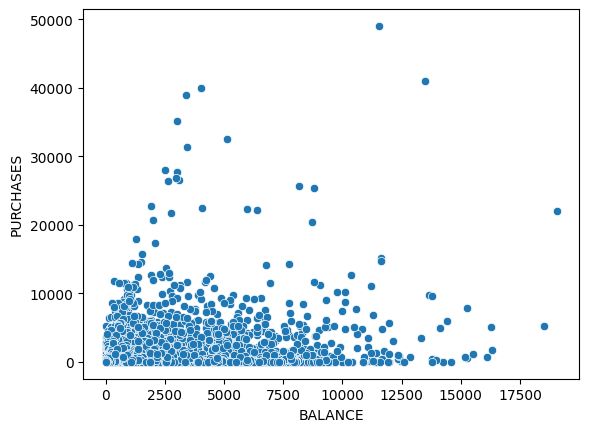

In [ ]:
sns.scatterplot(x='BALANCE', y='PURCHASES', data=datos_cc)

Las variables que cuentan con FREQUENCY son puntajes de 0 a 1, asociando el 0 como menos frecuente y 1 mas frecuente.

Por ejemplo, BALANCE_FREQUENCY es que se actualiza con mucha frecuencia el balance de la tarjeta, esto quiere decir que el consumidor utiliza mucho la tarjeta de crédito.

# Selección de variables


¿Qué variables se pueden utilizar para resolver este problema?

En general podrías considerar variables como, el saldo de la tarjeta, límite de crédito, las compras realizadas y los pagos de la tarjeta.


Variables como el BALANCE y la frecuencia con que se actualiza el balance es importante para dar una caracterización de los consumidores.

Las compras efectivas PURCHASES es otra variable ya que nos da un indicio de cuánto esta consumiendo el usuario con la tarjeta de crédito.


PRC_FULL_PAYMENT es el porcentaje del pago realizado por el usuario con respecto al pago total que corresponde del cliente.

Las variables que se utilizarán en este problema son:





In [ ]:
variables_cc=['BALANCE',	'BALANCE_FREQUENCY',	'PURCHASES',	'INSTALLMENTS_PURCHASES', 'PURCHASES_FREQUENCY',
              'PURCHASES_INSTALLMENTS_FREQUENCY','CREDIT_LIMIT',	'PAYMENTS',	'MINIMUM_PAYMENTS',	'PRC_FULL_PAYMENT']
print("Cantidad de variables", len(variables_cc))

Cantidad de variables 10


# Implementación de clúster

Para la implementación de segmentación es importante realizar una estandarización de variables.

In [ ]:
scaler = StandardScaler()
scaled_features= scaler.fit_transform(datos_cc[variables_cc])
scaled_features

array([[-0.74462486, -0.37004679, -0.42918384, ..., -0.54394191,
        -0.30550763, -0.53772694],
       [ 0.76415211,  0.06767893, -0.47320819, ...,  0.79685226,
         0.08768873,  0.21238001],
       [ 0.42660239,  0.50540465, -0.11641251, ..., -0.39950328,
        -0.09990611, -0.53772694],
       ...,
       [-0.75297728, -0.29709491, -0.40657175, ..., -0.5853667 ,
        -0.32957217,  0.30614422],
       [-0.75772142, -0.29709491, -0.47320819, ..., -0.59523762,
        -0.34081076,  0.30614422],
       [-0.58627829, -1.09958965,  0.03129519, ..., -0.59158925,
        -0.32709767, -0.53772694]])

# Implementación de K-means

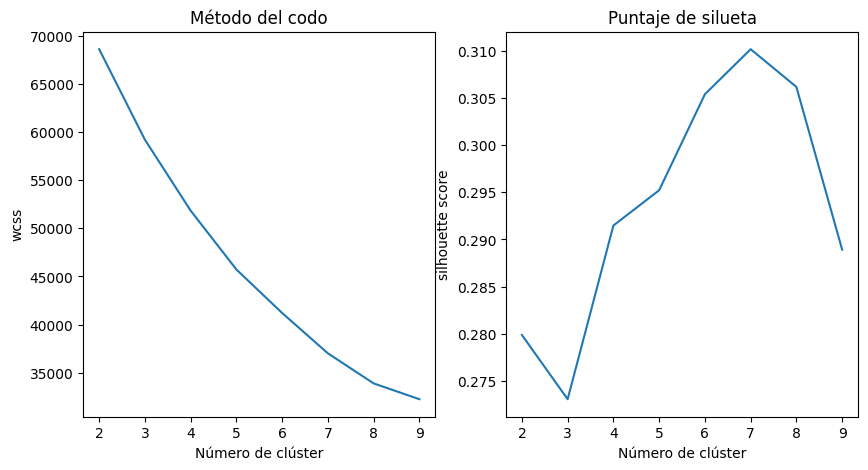

In [ ]:
silueta_score=[] # puntaje de silueta
wcss =[] #
n_clusters= range( 2,10)
for k in n_clusters:
  k_means=KMeans(k)
  k_means.fit(scaled_features)
  wcss.append(k_means.inertia_ )
  silueta = silhouette_score(scaled_features, k_means.labels_)
  silueta_score.append(silueta)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(n_clusters,wcss)
axs[0].set_title("Método del codo")
axs[0].set_xlabel("Número de clúster" )
axs[0].set_ylabel("wcss" )
axs[1].plot( n_clusters,silueta_score)
axs[1].set_title("Puntaje de silueta")
axs[1].set_xlabel("Número de clúster" )
axs[1].set_ylabel("silhouette score" )
plt.show()

Con el algoritmo de segmentación de K-means es claro que el número de clústeres es de 7, ya que se obtiene un puntaje de silueta Máximo en 7 y por el método del codo no es posible observar un posible punto de inflexión "codo".


In [ ]:
k_means=KMeans(7, random_state=123  )
k_means.fit(scaled_features )
datos_cc["labels_k_means"]= k_means.labels_
datos_cc["labels_k_means"] = datos_cc["labels_k_means"].astype(str)
datos_cc["labels_k_means"].value_counts()

,count
labels_k_means,
3,3228
5,2231
0,1122
6,1057
2,862
1,99
4,37


labels_k_means
3    0.373784
5    0.258337
0    0.129921
6    0.122395
2    0.099815
1    0.011464
4    0.004284
Name: proportion, dtype: float64


<Axes: xlabel='labels_k_means', ylabel='proportion'>

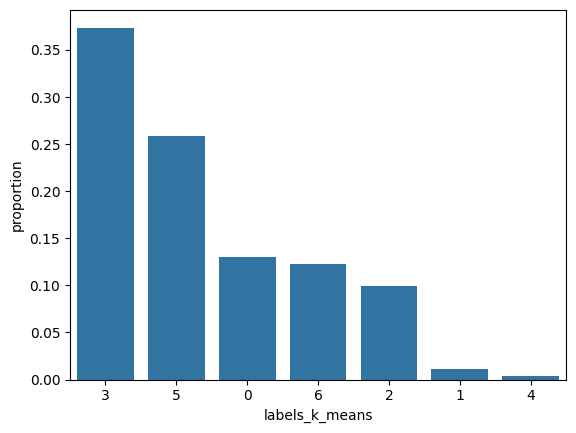

In [ ]:
print(datos_cc["labels_k_means"].value_counts(normalize=True))
sns.barplot(datos_cc["labels_k_means"].value_counts(normalize=True) )

Algo particular de seleccionar 7 clústeres es que el clúster 1 y 4 son muy poco frecuentes ¿habrá algo particular en estos clústeres?



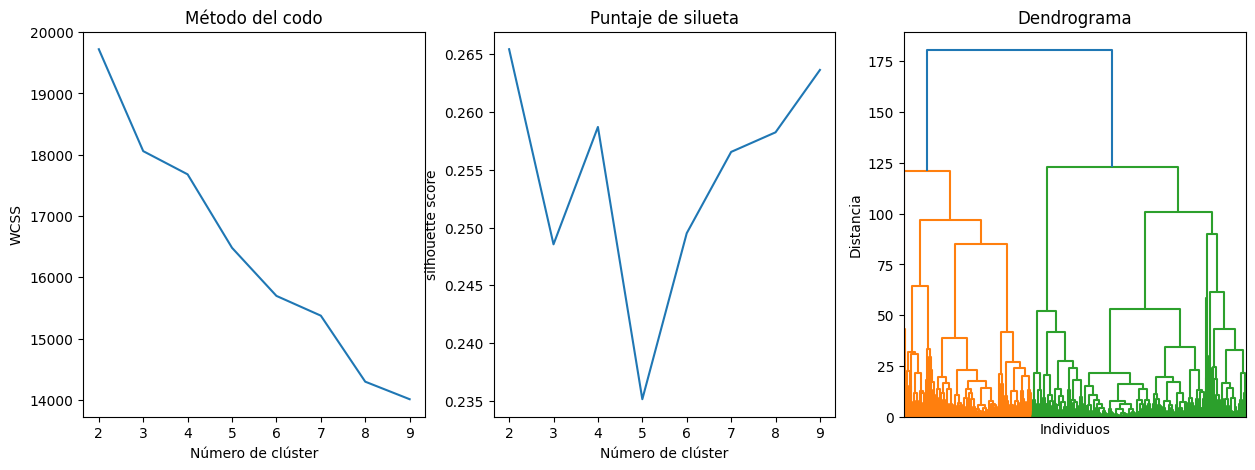

In [ ]:
silueta =[]
wcss =[]
n_cluster=range(2,10)
for i in n_cluster:
  jerarquico = AgglomerativeClustering(i)
  jerarquico.fit(scaled_features)
  scaled_temp= pd.DataFrame(scaled_features)
  scaled_temp["labels"]=jerarquico.labels_
  centros= scaled_temp.groupby("labels").mean()  # obteniendo centros
  argmin, distance =pairwise_distances_argmin_min(scaled_features,centros  )  # obteniendo distancias
  wcss.append(np.sum(distance) )
  score = silhouette_score(scaled_features,jerarquico.labels_ )
  silueta.append(score)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].plot( (n_cluster), wcss  )
axes[0].set_ylabel("WCSS")
axes[0].set_title("Método del codo")
axes[0].set_xlabel("Número de clúster" )
axes[1].plot( (n_cluster), silueta  )
axes[1].set_ylabel("silhouette score")
axes[1].set_title("Puntaje de silueta")
axes[1].set_xlabel("Número de clúster" )

# visualización clustering jerarquico
dist_matrix = linkage(scaled_features, method='ward')
# Visualizar el dendrograma
dendrogram(dist_matrix,no_labels=True)
axes[2].set_title('Dendrograma')
axes[2].set_xlabel('Individuos')
axes[2].set_ylabel('Distancia')
plt.show()


Con clúster jerárquico se observa que, con el método del no es claro un punto de inflexión. Utilizando el el puntaje de silueta, el máximo puntaje se obtiene con 2 clústeres, sin embargo, con el método del codo se observa una perdida significativa entre 2 a 3 clústeres. En el puntaje se silueta se observa que a medida que aumentan el número de clústeres, se observa mucha variación, con 9 clústeres se alcanza un puntaje similar que con 2 clústeres, además de que el dendograma nos sugiere 2 clústeres, se observa que 4 clústeres podría ser otra opción.

Finalmente se observa que por estos métodos puede ser entre 2 a 4 clústeres.



In [ ]:
hc=AgglomerativeClustering(4 )
hc.fit(scaled_features )
datos_cc["labels_hc"]= hc.labels_
datos_cc["labels_hc"] = datos_cc["labels_hc"].astype(str)
datos_cc["labels_hc"].value_counts()

,count
labels_hc,
0,4088
1,3216
2,1297
3,35


In [ ]:
#Si escogieramos 2
hc=AgglomerativeClustering(2 )
hc.fit(scaled_features )
datos_cc["labels_hc"]= hc.labels_
datos_cc["labels_hc"] = datos_cc["labels_hc"].astype(str)
datos_cc["labels_hc"].value_counts()

,count
labels_hc,
0,5385
1,3251


In [ ]:
#Si escogieramos 3
hc=AgglomerativeClustering(3 )
hc.fit(scaled_features )
datos_cc["labels_hc"]= hc.labels_
datos_cc["labels_hc"] = datos_cc["labels_hc"].astype(str)
datos_cc["labels_hc"].value_counts()

,count
labels_hc,
1,4088
0,3251
2,1297


# Interpretación de resultados

Ahora, para el caso de K-means se han seleccionado 6 clústeres, mientras que con clustering jerárquico 4. La idea es interpretar los clústeres.

Los gráficos apropiados para visualizar son los box-plot.



<Axes: xlabel='labels_k_means', ylabel='BALANCE'>

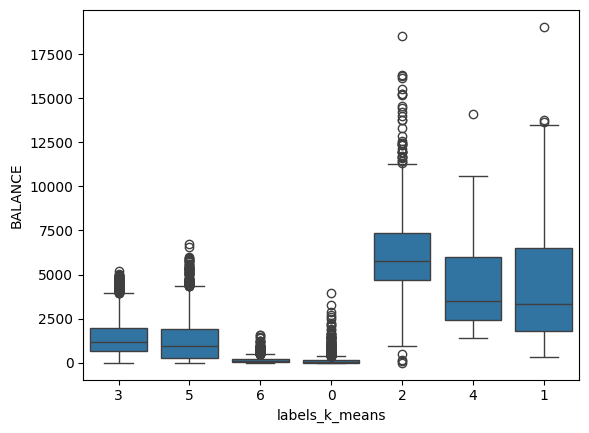

In [ ]:
sns.boxplot(x="labels_k_means", y="BALANCE", data=datos_cc)

# Interpretación con K-means

labels_k_means
3    0.373784
5    0.258337
0    0.129921
6    0.122395
2    0.099815
1    0.011464
4    0.004284
Name: proportion, dtype: float64


<Axes: xlabel='labels_k_means', ylabel='proportion'>

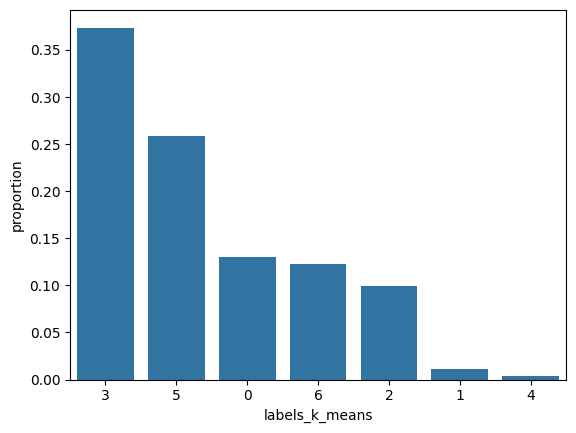

In [ ]:
print(datos_cc["labels_k_means"].value_counts(normalize=True))
sns.barplot(datos_cc["labels_k_means"].value_counts(normalize=True) )

Se observa que, el clúster 3, son los consumidores más frecuentes representando el 37.37% de los usuarios, seguido del clúster 5 que representa un 25.83%, ambos clústeres representan el 63% de los usuarios. El clúster 1 y 4 son los clústeres menos frecuentes, en particular el clúster 1 y 4 son los menos frecuentes.

In [ ]:
px.box(datos_cc, x='labels_k_means', y='BALANCE',color="labels_k_means",
       points=False, # No muestra los puntos atípicos extendiendo las barras
             title='BALANCE: Boxplot por clúster')

Con respecto al saldo en la tarjeta, se observa que el clúster 2 es el clúster que en promedio presenta un mayor balance (5.7 mil), además el clúster 4 y 1 (3.5 mil) presentan un balance promedio alto con respecto a los demás clústeres, además de que son grupos poco frencuentes. Los clústeres que resperentan el 63% de los usuarios presentan un promedio de balance similar, ocupando un tercer puesto (mil a 1.2 mil). Mientras que el clúster 6 y 0 son los que presentan un Balance mucho menor en promedio (100).

In [ ]:
px.box(datos_cc, x='labels_k_means', y='BALANCE_FREQUENCY',color="labels_k_means",
      #  points=False, # No muestra los puntos atípicos extendiendo las barras
             title='BALANCE_FREQUENCY: Boxplot por clúster')

Para la frecuencia en el saldo, se encuentra que el clúster 0 es el grupo que menor frecuencia promedio presenta en la actualización de su saldo, esto puede indicar que son consumidores que utilizan con poca frecuencia su tarjeta de crédito.

In [ ]:
px.box(datos_cc, x='labels_k_means', y='PURCHASES',color="labels_k_means",
      #  points=False, # No muestra los puntos atípicos extendiendo las barras
             title='PURCHASES: Boxplot por clúster')

Para el gasto realizado por las compras realizadas, se observa que el clúster 1 es el que realiza más compras en promedio (10 mil) y mayor variabilidad con la tarjeta, seguido del clúster 5 y 6 mostrando un monto en promedio (mil ), seguido del clúster 2  mostrando una variabilidad similar entre el clúster 5 y 6 y un promedio de 332, donde el clúster 3 y 0 muestran un promedio menor.

In [ ]:
px.box(datos_cc, x='labels_k_means', y='INSTALLMENTS_PURCHASES',color="labels_k_means",
      #  points=False, # No muestra los puntos atípicos extendiendo las barras
             title='INSTALLMENTS_PURCHASES: Boxplot por clúster')

Con respecto a la compra destinado a plazos, se observa un comportamiento similar con las compras.

¿Qué variable se podría crear y análizar?
**R/. Porcentaje de compras a plazos para ver cual es el porcentaje que los clientes destinan a plazos**

In [ ]:
datos_cc['Porcentaje_Cuotas']= datos_cc['INSTALLMENTS_PURCHASES']/datos_cc['PURCHASES']*100
datos_cc['Porcentaje_Cuotas']= datos_cc['Porcentaje_Cuotas'].fillna(0) #remplazar los valores faltantes por el valor que yo le indique
datos_cc['Porcentaje_Cuotas']

,Porcentaje_Cuotas
0,100.0
1,0.0
2,0.0
4,0.0
5,100.0
...,...
8943,0.0
8945,100.0
8947,100.0
8948,0.0


In [ ]:
px.box(datos_cc, x='labels_k_means', y='Porcentaje_Cuotas',color="labels_k_means",
      #  points=False, # No muestra los puntos atípicos extendiendo las barras
             title='Porcentaje_Cuotas: Boxplot por clúster')

El cluster 3 es el más frecuente y el que menos destina a cuotas

In [ ]:
px.box(datos_cc, x='labels_k_means', y='PRC_FULL_PAYMENT',color="labels_k_means",
      #  points=False, # No muestra los puntos atípicos extendiendo las barras
             title='PRC_FULL_PAYMENT: Boxplot por clúster')

Con respecto al porcentaje, se observa que el clúster 6 es el clúster que en promedio realiza un pago porcentual mas alto (83%) con respecto a los demás clústeres. El clúster 1 presenta una mayor variabilidad con respecto al pago porcentual de todo el pago.

El que más porcentaje a la deuda hace, es el cluster 6.

In [ ]:
px.box(datos_cc, x='labels_k_means', y='PURCHASES_FREQUENCY',color="labels_k_means",
      #  points=False, # No muestra los puntos atípicos extendiendo las
             title='PURCHASES_FREQUENCY: Boxplot por clúster')

Con respecto a la frecuencia de compras, los clústeres 5, 6 y 1 muestran una mayor frecuencia promedio en las compras, el clúster 2 y 4 presentan una mayor variabilidad. El clúster 3 y 0 muestran una menor frecuencia promedio en las compras.

In [ ]:
px.box(datos_cc, x='labels_k_means', y='PURCHASES_INSTALLMENTS_FREQUENCY',color="labels_k_means",
      #  points=False, # No muestra los puntos atípicos extendiendo las barras
             title='PURCHASES_INSTALLMENTS_FREQUENCY: Boxplot por clúster')

Esta variable tiene que ver con la frecuencia pero de compras a plazo. Un comportamiento similar que en el gráfico anterior.

In [ ]:
px.box(datos_cc, x='labels_k_means', y='CREDIT_LIMIT',color="labels_k_means",
      #  points=False, # No muestra los puntos atípicos extendiendo las barras
             title='CREDIT_LIMIT: Boxplot por clúster')

Con respecto al límite de crédito, el clúster 1 y 2 son los que en promedio tienen un límite de crédito mayor que los demás clústeres, donde el clúster 1 presenta mayor variabilidad.

In [ ]:
px.box(datos_cc, x='labels_k_means', y='PAYMENTS',color="labels_k_means",
      #  points=False, # No muestra los puntos atípicos extendiendo las barras
             title='PAYMENTS: Boxplot por clúster')

In [ ]:
px.box(datos_cc, x='labels_k_means', y='MINIMUM_PAYMENTS',color="labels_k_means",
      #  points=False, # No muestra los puntos atípicos extendiendo las barras
             title='MINIMUM_PAYMENTS: Boxplot por clúster')

En general tenemos que:


### Clúster 0

El clúster 0 está compuesto por usuarios que utilizan su tarjeta con poca frecuencia, mostrando un saldo promedio muy bajo de 100. Estos usuarios también tienen un gasto menor en compras y presentan una menor frecuencia en las compras realizadas.

### Clúster 1
El clúster 1 representa a uno de los grupos menos frecuentes de usuarios, aunque tienen un saldo promedio alto en sus tarjetas, alcanzando los 3.5 mil. Estos usuarios realizan un gasto considerable en compras, con un promedio de 10 mil, y muestran una alta variabilidad tanto en gasto como en el pago porcentual. Además, tienen una alta frecuencia de compras y un límite de crédito mayor que otros clústeres, presentando también una alta variabilidad en este aspecto.

### Clúster 2
Los usuarios del clúster 2 se destacan por tener el mayor balance promedio en sus tarjetas, con 5.7 mil. Aunque su gasto en compras es menor en comparación con otros clústeres, con un promedio de 332 y una variabilidad similar a los clústeres 5 y 6, estos usuarios también tienen un límite de crédito alto, comparable al del clúster 1. La frecuencia de compras en este clúster presenta una mayor variabilidad.

### Clúster 3
El clúster 3 incluye a los consumidores más frecuentes, representando el 37.37% de los usuarios. Estos usuarios tienen un saldo promedio similar al clúster 5, entre mil y 1.2 mil. Sin embargo, su gasto en compras es menor comparado con otros clústeres y también presentan una menor frecuencia de compras. Este clúster no se destaca por un límite de crédito alto ni por una gran variabilidad en otros aspectos.

### Clúster 4
El clúster 4 es uno de los menos frecuentes, similar al clúster 1, pero con un saldo promedio alto de 3.5 mil en sus tarjetas. Aunque no se especifica el gasto en compras, estos usuarios muestran una mayor variabilidad en la frecuencia de compras. Este grupo es poco frecuente y no se menciona un límite de crédito alto, pero su alto saldo promedio los distingue.

### Clúster 5
El clúster 5 representa al segundo grupo más frecuente de usuarios, con un 25.83% del total. Estos usuarios tienen un saldo promedio similar al del clúster 3, entre mil y 1.2 mil, y su gasto en compras es de alrededor de mil. Además, tienen una alta frecuencia de compras, aunque no se especifica el límite de crédito ni otros detalles sobre la variabilidad en sus hábitos de gasto.

### Clúster 6
Los usuarios del clúster 6 presentan un saldo promedio muy bajo de 100, pero destacan por realizar un pago porcentual alto en comparación con otros clústeres, alcanzando un promedio del 83%. Aunque su gasto en compras es de alrededor de mil, tienen una alta frecuencia de compras, lo que los distingue en términos de uso habitual de su tarjeta.

### Clúster 7
Para el clúster 7, no se proporciona información específica sobre la frecuencia de uso, saldo en tarjeta, gasto en compras, pago porcentual, frecuencia de compras o límite de crédito. La falta de detalles dificulta una descripción precisa de este grupo.


# Interpretación con Clustering jerárquico



labels_hc
0    0.473367
1    0.372395
2    0.150185
3    0.004053
Name: proportion, dtype: float64


<Axes: xlabel='labels_hc', ylabel='proportion'>

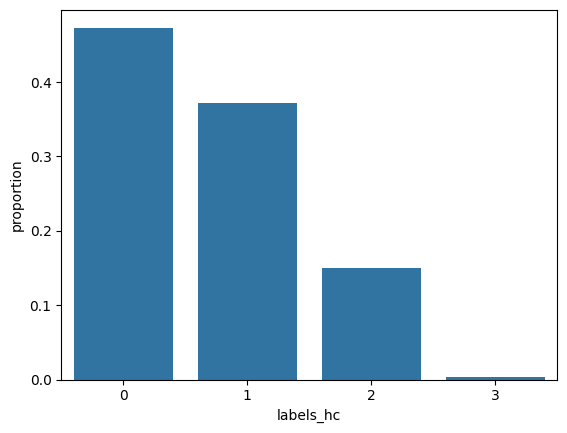

In [ ]:
print(datos_cc["labels_hc"].value_counts(normalize=True))
sns.barplot(datos_cc["labels_hc"].value_counts(normalize=True) )

Se observa que, el clúster 0, son los consumidores más frecuentes representando el 47.32% de los usuarios, seguido del clúster 1 que representa un 37.24%, ambos clústeres representan el 84% de los usuarios. El clúster 3 es el clúster menos frecuente, representando menos del 1% de los consumidores.

In [ ]:
px.box(datos_cc, x='labels_hc', y='BALANCE',color="labels_hc",
       points=False, # No muestra los puntos atípicos extendiendo las barras
             title='BALANCE: Boxplot por clúster')

Con respecto al saldo en la tarjeta, se observa que el clúster 3 es el clúster que en promedio presenta un mayor balance (3.4 mil), el clúster 0 presenta un promedio de 1.4 mil, seguido del clúster 1 presentando un promedio de 574. Por último el clúster 2 presentando un promedio de 38.


In [ ]:
px.box(datos_cc, x='labels_hc', y='BALANCE_FREQUENCY',color="labels_hc",
      #  points=False, # No muestra los puntos atípicos extendiendo las barras
             title='BALANCE_FREQUENCY: Boxplot por clúster')

Para la frecuencia en el saldo, se encuentra que el clúster 2 es el grupo que menor frecuencia promedio presenta en la actualización de su saldo, esto puede indicar que son consumidores que utilizan con poca frecuencia su tarjeta de crédito.

In [ ]:
px.box(datos_cc, x='labels_hc', y='PURCHASES',color="labels_hc",
      #  points=False, # No muestra los puntos atípicos extendiendo las barras
             title='PURCHASES: Boxplot por clúster')

Para el gasto realizado por las compras realizadas, se observa que el clúster 3 es el que realiza más compras en promedio (22 mil) y mayor variabilidad con la tarjeta, seguido del clúster 1 mostrando un monto en promedio (1.1 mil ).  Los clústeres 0 y 2 muestran un promedio menor.

In [ ]:
px.box(datos_cc, x='labels_hc', y='INSTALLMENTS_PURCHASES',color="labels_hc",
      #  points=False, # No muestra los puntos atípicos extendiendo las barras
             title='INSTALLMENTS_PURCHASES: Boxplot por clúster')

Con respecto a la compra destinado a plazos, se observa un comportamiento similar con las compras.

¿Qué variable se podría crear y análizar?

In [ ]:
px.box(datos_cc, x='labels_hc', y='PRC_FULL_PAYMENT',color="labels_hc",
      #  points=False, # No muestra los puntos atípicos extendiendo las barras
             title='PRC_FULL_PAYMENT: Boxplot por clúster')

Con respecto al porcentaje, se observa que el clúster 0 es el clúster que el 75%  realiza un pago porcentual de 0% ,  El clúster 3 presenta una mayor variabilidad con respecto al pago porcentual de todo el pago.

In [ ]:
px.box(datos_cc, x='labels_hc', y='PURCHASES_FREQUENCY',color="labels_hc",
      #  points=False, # No muestra los puntos atípicos extendiendo las
             title='PURCHASES_FREQUENCY: Boxplot por clúster')

Con respecto a la frecuencia de compras, los clústeres 1 y 3 muestran una mayor frecuencia promedio en las compras, el clúster 0 y 2 presentan una mayor variabilidad, donde el clúster dos muestra una frecuencia de compra promedio mayor al clúster 0.

In [ ]:
px.box(datos_cc, x='labels_hc', y='PURCHASES_INSTALLMENTS_FREQUENCY',color="labels_hc",
      #  points=False, # No muestra los puntos atípicos extendiendo las barras
             title='PURCHASES_INSTALLMENTS_FREQUENCY: Boxplot por clúster')

Esta variable tiene que ver con la frecuencia pero de compras a plazo. Un comportamiento similar que en el gráfico anterior.

In [ ]:
px.box(datos_cc, x='labels_hc', y='CREDIT_LIMIT',color="labels_hc",
      #  points=False, # No muestra los puntos atípicos extendiendo las barras
             title='CREDIT_LIMIT: Boxplot por clúster')

Con respecto al límite de crédito, el clúster 3 (15 mil) tienen un límite de crédito promedio mayor que los demás clústeres, el clúster 2 es el clúster con un menor límite de crédito promedio (2.5 mil).



In [ ]:
px.box(datos_cc, x='labels_hc', y='PAYMENTS',color="labels_hc",
      #  points=False, # No muestra los puntos atípicos extendiendo las barras
             title='PAYMENTS: Boxplot por clúster')

In [ ]:
px.box(datos_cc, x='labels_hc', y='MINIMUM_PAYMENTS',color="labels_hc",
      #  points=False, # No muestra los puntos atípicos extendiendo las barras
             title='MINIMUM_PAYMENTS: Boxplot por clúster')

En general tenemos que:

### Clúster 0
El clúster 0 agrupa a los consumidores más frecuentes, representando el 47.32% de los usuarios. Aunque su frecuencia de uso es alta, el saldo promedio en sus tarjetas es de 1.4 mil, que es moderado en comparación con otros clústeres. Estos usuarios tienden a realizar compras con un gasto promedio más bajo, pero muestran una alta variabilidad en la frecuencia de sus compras. Además, el 75% de los usuarios en este clúster realiza pagos porcentuales de 0%, lo que podría indicar que no pagan el total de su deuda o utilizan sus tarjetas de manera muy específica.

### Clúster 1
El clúster 1, que representa al 37.24% de los usuarios, también está compuesto por consumidores frecuentes. Aunque el saldo promedio en sus tarjetas es más bajo, de 574, estos usuarios realizan compras con un gasto promedio de 1.1 mil, lo que indica un uso activo aunque no tan elevado como el clúster 3. La frecuencia de compras en este clúster es alta, lo que los distingue por un uso constante de sus tarjetas. Aunque no se menciona la variabilidad en el pago porcentual, es notable que este grupo también juega un papel importante en el uso general de las tarjetas.

### Clúster 2
El clúster 2 es menos frecuente en comparación con los anteriores, y esto se refleja en su saldo promedio muy bajo de 38. Este grupo muestra una baja frecuencia en la actualización de su saldo, lo que sugiere un uso poco frecuente de la tarjeta de crédito. A pesar de esto, la frecuencia de compras en este clúster es mayor que la del clúster 0, aunque el gasto promedio y el límite de crédito son los más bajos, con solo 2.5 mil.

### Clúster 3
El clúster 3, aunque representa menos del 1% de los usuarios, destaca por tener el mayor saldo promedio de 3.4 mil y el mayor límite de crédito promedio de 15 mil. Este grupo realiza compras con un gasto promedio significativamente alto de 22 mil, mostrando también la mayor variabilidad tanto en el gasto como en el pago porcentual de sus deudas. Además, aunque son menos frecuentes, estos usuarios tienen una alta frecuencia promedio en las compras, lo que sugiere un uso intensivo y posiblemente estratégico de sus tarjetas.